<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/RandomForest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Deep_learning/FundusPhoto/result.csv", index_col=0, sep=",")
df


,filename,age,set,cropped_A2,cropped_A2_pretrained,cropped_B3,cropped_B3pretrained,disc_A2,disc_A2_pretrained,disc_B3,disc_B3_pretrained,vascular_A2,vascular_A2_pretrained,vascular_B3,vascular_B3_pretrained,macula_A2,macula_A2_pretrained,macula_B3,macula_B3_pretrained
0,img00085008_00_1R.jpg,61,val,42.550665,51.511717,45.267197,48.228016,44.259751,60.388803,49.019647,57.370079,39.733568,56.994337,37.184125,65.403533,49.398333,63.834465,45.315519,64.566314
1,img00085024_00_1R.jpg,29,val,39.297953,27.813551,34.693065,30.219698,26.992634,37.555158,34.393159,28.256360,43.488920,39.154470,35.333204,50.786895,32.094574,30.836606,40.556285,32.959792
2,img00241280_10_1R.jpg,51,train,50.525779,57.090443,55.625671,55.247718,55.658686,53.555816,53.484726,63.062501,60.073453,54.546875,61.437273,66.778558,68.798459,64.358580,65.383965,60.088068
3,img00265140_00_1R.jpg,29,train,37.621737,31.148827,36.938146,33.577043,37.484571,31.255072,34.735942,35.358283,49.096131,29.550302,43.482432,55.882704,33.237335,33.163512,41.000220,32.129413
4,img00265140_00_2L.jpg,29,train,45.709464,28.956094,41.004908,32.249141,52.366054,36.308649,35.845736,42.669216,47.214234,23.765880,41.661096,35.372418,38.583675,32.522386,51.551360,33.535883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,img76791392_10_1R.jpg,38,test,27.728298,35.313144,31.801829,38.302854,23.495825,38.568458,33.258343,42.240074,38.404098,43.046537,29.530483,46.944967,34.177482,47.200292,34.066108,39.392710
1410,img76843122_10_1R.jpg,49,train,54.683352,42.622042,52.932787,55.145103,53.488880,49.396980,56.750482,47.917736,48.524040,50.074857,45.814630,62.571549,47.415417,56.604981,49.924394,48.442462
1411,img76843122_11_1R.jpg,49,val,51.311404,44.966671,53.484696,52.670932,47.552106,55.660129,57.124478,53.338772,42.628607,47.078547,47.271791,61.643904,43.878964,54.082513,53.915966,59.205514
1412,img76888512_00_1R.jpg,74,val,55.601197,67.208940,49.137861,74.466658,53.561741,74.132806,58.818334,71.472144,52.029234,61.757177,54.857647,64.616156,52.878857,66.580504,56.259942,72.109437


In [97]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 

#sorted(sklearn.metrics.SCORERS.keys())


#indexの内容を確認
#df.columns.values.tolist()

FEATURE_COLS=[
 'cropped_A2',
 'cropped_A2_pretrained',
 'cropped_B3',
 'cropped_B3pretrained',
 'disc_A2',
 'disc_A2_pretrained',
 'disc_B3',
 'disc_B3_pretrained',
 'vascular_A2',
 'vascular_A2_pretrained',
 'vascular_B3',
 'vascular_B3_pretrained',
 'macula_A2',
 'macula_A2_pretrained',
 'macula_B3',
 'macula_B3_pretrained']

"""
FEATURE_COLS=[
 'cropped_A2',
 'cropped_B3']
"""

# 訓練データとテストデータに分割する。
from sklearn.model_selection import train_test_split
# TODO:層別サンプリング train, test = train_test_split(df, test_size=0.20, stratify=df["町区分"], random_state=100)
train, test = train_test_split(df, test_size=0.20,random_state=100)

X_train = train[FEATURE_COLS]
Y_train = train["age"]
X_test = test[FEATURE_COLS]
Y_test = test["age"]


#**Prediction accuracy for each model**

In [109]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 


#　　精度確認
# 自由度調整済みr2を算出
def adjusted_r2(X,Y):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, X)
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-2)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = X_test

    print("adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train)))
    print("adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test)))   
    print("平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1)))) 
    print("MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)))
    print("MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)))
    print("RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))))
    print("RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test))) #better if result = 1.253

for i in FEATURE_COLS:
    X_train = train[i]
    Y_train = train["age"]
    X_test = test[i]
    Y_test = test["age"]
    print(str(i))
    get_model_evaluations(X_train,Y_train,X_test,Y_test)
    print("")

cropped_A2
adjusted_r2(train)     :0.6768364941774625
adjusted_r2(test)      :0.6552439046502634
平均誤差率(test)       :0.1376964891000603
MAE(test)              :7.192821288904593
MedianAE(test)         :6.039247750000001
RMSE(test)             :8.950277453162954
RMSE(test) / MAE(test) :1.244334746223899

cropped_A2_pretrained
adjusted_r2(train)     :0.9065430255444364
adjusted_r2(test)      :0.9054572644352865
平均誤差率(test)       :0.06702599248383183
MAE(test)              :3.4286524205300344
MedianAE(test)         :2.534624099999988
RMSE(test)             :4.686996226737096
RMSE(test) / MAE(test) :1.3670082737673757

cropped_B3
adjusted_r2(train)     :0.6175387709876337
adjusted_r2(test)      :0.6045321781592885
平均誤差率(test)       :0.1378216084238661
MAE(test)              :7.6079399463250885
MedianAE(test)         :6.863088490000003
RMSE(test)             :9.585970710149113
RMSE(test) / MAE(test) :1.2599955806406549

cropped_B3pretrained
adjusted_r2(train)     :0.860775308921399
adjusted_

#**Analysis using XGBoost**

In [45]:
# Grid Search用のパラメータ作成。
# あまり組み合わせが多いと時間がかかる(time consuming)
params = {
        'eta': [0.01],             # default = 0.3      
        'gamma': [1,2,3],            # default = 0
        'max_depth': [7,8,9],      # default = 6
        'min_child_weight': [1],   # default = 1
        'subsample': [0.8,1.0],        # default = 1
        'colsample_bytree': [0.8,1.0], # default = 1
        }
kf = KFold(n_splits=5, shuffle = True, random_state = 1)

#最適解探索
model = xgb.XGBRegressor(objective ='reg:squarederror')
grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=2, cv=kf.split(X_train,Y_train), verbose=3)


grid.fit(X_train,Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   27.2s
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:   40.8s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f91edf84b50>,
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    object...
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=2,
             param_grid={'colsample_bytree': [0.8, 1.0], 'eta': [0.01],
            

In [ ]:
print('ベストスコア:',grid.best_score_, sep="\n")
print('\n')
print('ベストestimator:',grid.best_estimator_,sep="\n")
print('\n')
print('ベストparams:',grid.best_params_,sep="\n")

print(pd.DataFrame(grid.cv_results_))

In [47]:
# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253



# Grid Searchで一番精度が良かったモデル
bestmodel = grid.best_estimator_

get_model_evaluations(X_train,Y_train,X_test,Y_test,bestmodel)


('adjusted_r2(train)     :0.9980511070633832',
 'adjusted_r2(test)      :0.955168143097609',
 '平均誤差率(test)       :0.03968267421164039',
 'MAE(test)              :2.109084692102439',
 'MedianAE(test)         :1.4124488830566406',
 'RMSE(test)             :3.140230618238538',
 'RMSE(test) / MAE(test) :1.488906837168403')

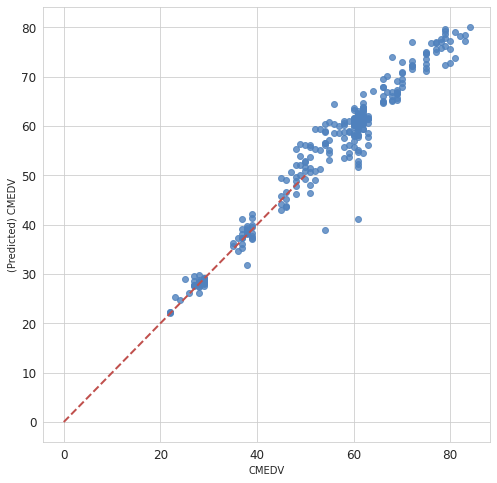

In [48]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 8,8      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=Y_test, y=bestmodel.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"CMEDV")
ax.set_ylabel(u"(Predicted) CMEDV")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,10,20,30,40,50],[0,10,20,30,40,50], linewidth=2, color="#C0504D",ls="--")

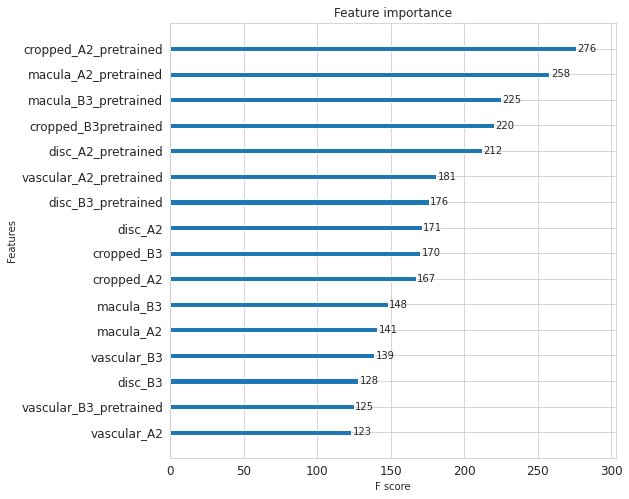

In [10]:
xgb.plot_importance(bestmodel)

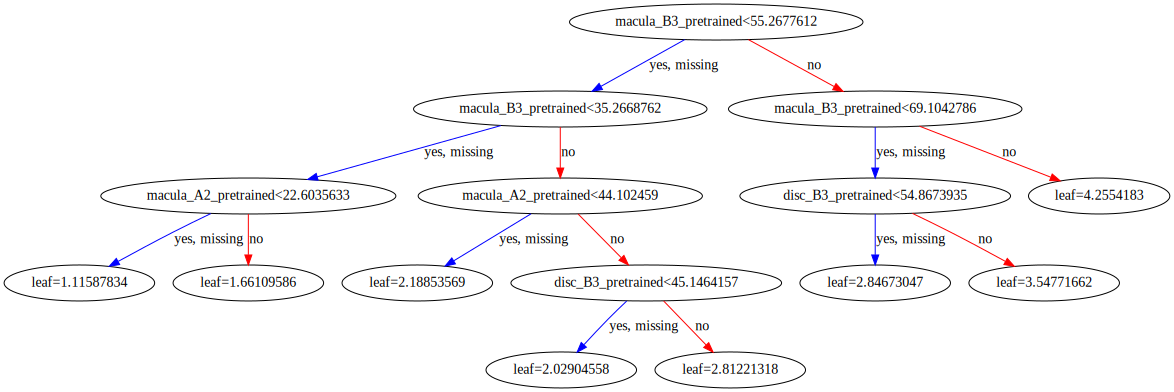

In [ ]:
xgb.to_graphviz(bestmodel, num_trees=5)


#**Analysis using RandomForest**

In [98]:
#Create model
import numpy as np
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train,Y_train) 

"""
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=2525, verbose=0, warm_start=False)
"""



#　　精度確認
# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253

get_model_evaluations(X_train,Y_train,X_test,Y_test,model)

16
16


('adjusted_r2(train)     :0.9926585147646416',
 'adjusted_r2(test)      :0.9533268950431855',
 '平均誤差率(test)       :0.040826684105547836',
 'MAE(test)              :2.1819787985865724',
 'MedianAE(test)         :1.3999999999999986',
 'RMSE(test)             :3.2040665415728893',
 'RMSE(test) / MAE(test) :1.4684223988099234')

In [41]:
#Grid search
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,Y_train)



print('ベストスコア:',grid.best_score_, sep="\n")
print('\n')
print('ベストestimator:',grid.best_estimator_,sep="\n")
print('\n')
print('ベストparams:',grid.best_params_,sep="\n")

print(pd.DataFrame(grid.cv_results_))

# Grid Searchで一番精度が良かったモデル
bestmodel = grid.best_estimator_
get_model_evaluations(X_train,Y_train,X_test,Y_test,bestmodel)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

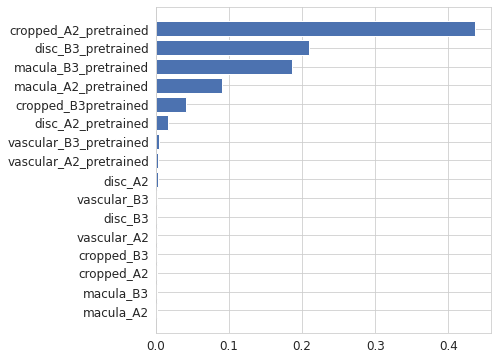

,features,importances
0,cropped_A2_pretrained,0.436555
1,disc_B3_pretrained,0.208882
2,macula_B3_pretrained,0.186082
3,macula_A2_pretrained,0.0901868
4,cropped_B3pretrained,0.0412738
5,disc_A2_pretrained,0.0164726
6,vascular_B3_pretrained,0.00459427
7,vascular_A2_pretrained,0.00328402
8,disc_A2,0.00214456
9,vascular_B3,0.00194403


In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()


feature_importances = pd.DataFrame([features, importances]).T
feature_importances.columns = ['features', 'importances']
df_s = feature_importances.sort_values('importances', ascending=False).reset_index(drop=True)
df_s

In [ ]:
"""
plt.figure(figsize=(8,8))
plt.title('Importances')
plt.rcParams['font.size']=10
sns.barplot(y='features', x='importances', data=df_s, palette='viridis')
"""

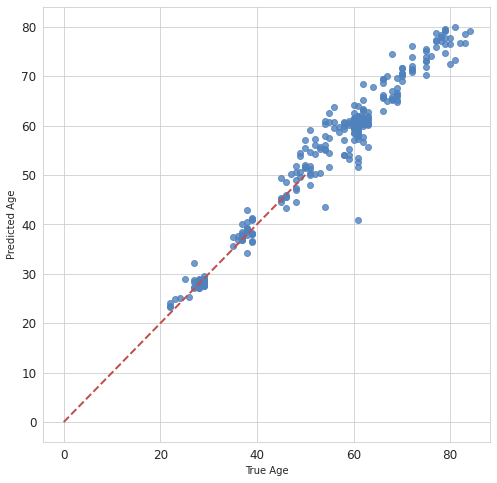

In [52]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 8,8      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=Y_test, y=model.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"True Age")
ax.set_ylabel(u"Predicted Age")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,10,20,30,40,50],[0,10,20,30,40,50], linewidth=2, color="#C0504D",ls="--")

#**Analysis using neural network**

In [31]:
#正規化する
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

#モデル作成
import numpy as np
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(alpha=0.1, hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive', max_iter=500, random_state=42, solver="lbfgs", early_stopping=True) 
model.fit(X_train,Y_train) 


"""
初期設定：

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
"""


# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253

get_model_evaluations(X_train,Y_train,X_test,Y_test,model)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


('adjusted_r2(train)     :0.9985855464473465',
 'adjusted_r2(test)      :0.9232505451500271',
 '平均誤差率(test)       :0.0559891829790846',
 'MAE(test)              :2.9263694308576333',
 'MedianAE(test)         :2.0810153147193873',
 'RMSE(test)             :4.108713223309058',
 'RMSE(test) / MAE(test) :1.4040309401759006')

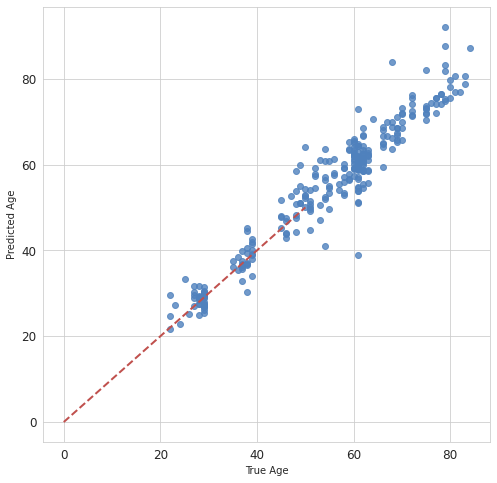

In [32]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 8,8      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=Y_test, y=model.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"True Age")
ax.set_ylabel(u"Predicted Age")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,10,20,30,40,50],[0,10,20,30,40,50], linewidth=2, color="#C0504D",ls="--")